<a href="https://colab.research.google.com/github/GHes31415/OT/blob/main/bezier_gauss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline 
import numpy as np
import torch
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation
from torch.distributions.multivariate_normal import MultivariateNormal
import imageio
import os
from matplotlib import cm


In [2]:
normal = lambda x,mu,sigma : np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

# Algorithm for computing bezier interpolation 

In [3]:
def bezier_interpolation(t, points):
  # Only working for 3 points 
  p1 = points[0].unsqueeze(-1)
  p2 = points[1].unsqueeze(-1)
  p3 = points[2].unsqueeze(-1)

  c1 = (1-t)*p1 + t*p2
  c2 = (1-t)*p2 + t*p3
  return c1*(1-t) + c2*t

Test in 2D. This test matches the interpolation for 1D Gaussians. This is the path in the mean-variance space

In [4]:
coefs = torch.tensor([[-4,3],[-8,1/8],[8,3]])
t = torch.linspace(0,1,50)
interp = bezier_interpolation(t, coefs)
x = interp[0,:]
y = interp[1,:]

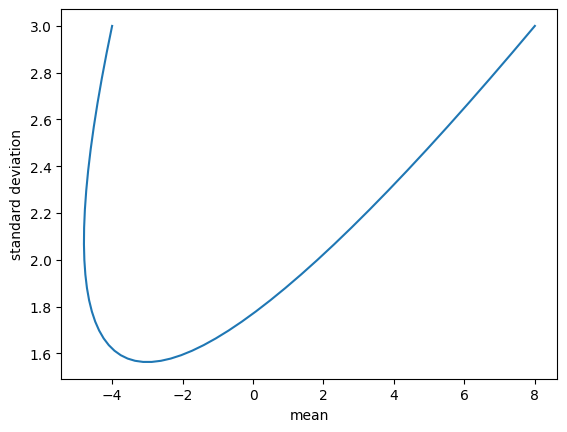

In [5]:
plt.plot(x,y)
plt.xlabel('mean')
plt.ylabel('standard deviation')
plt.show()

# *Test* for 1D Gaussians

In [6]:
def plot_gaussian_density_transition(num, grid, interp_means, interp_var):
  N = len(interp_means)
  fig = plt.figure(figsize = (10,6))

  ax = plt.axes(projection='3d')

  cmap = plt.get_cmap('brg')
  
  colors =[ cmap(i) for i in np.linspace(0,1,N)]

  for i ,color in enumerate(colors,start = 0):
    t = i/N*np.ones(num)
    y = normal(grid,interp_means[i],interp_var[i])
    ax.plot3D(t,grid,y, alpha = 0.75, color = color)
    #plt.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('x')
    ax.set_zlabel('G(x)')

  plt.show()

def transition_gaussian_1d( grid, interp_means, interp_var):

  cmap = plt.get_cmap('brg')
  
  colors =[ cmap(i) for i in np.linspace(0,1,N)]
  for i ,color in enumerate(colors,start = 0):

    y = normal(grid,interp_means[i],interp_var[i])

    plt.plot(grid,y, alpha = 0.75, color = color)

  plt.show()


In [7]:
N = 50

vect_means = torch.tensor([0,-8,8])
vect_var = torch.tensor([1,5,1])

t = torch.linspace(0,1,N)
x = np.linspace(-10,10,150)
interp_means = bezier_interpolation(t, vect_means).numpy()
interp_var = bezier_interpolation(t, vect_var).numpy()

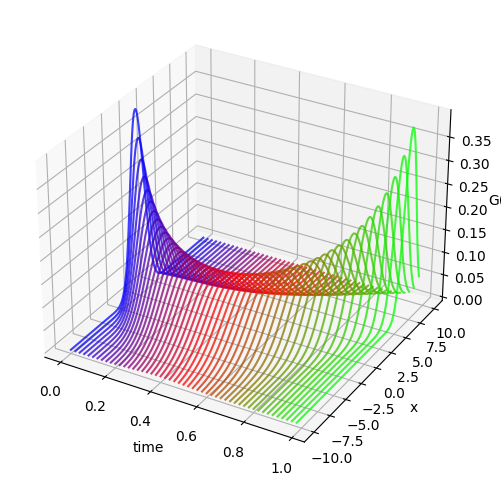

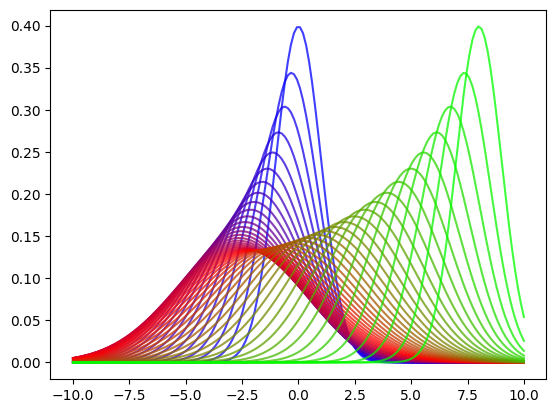

In [8]:
plot_gaussian_density_transition(150, x, interp_means, interp_var)
transition_gaussian_1d(x,interp_means, interp_var)

# 


In [9]:
def _mat_sqrt(A):
  L,V = torch.linalg.eig(A)
  return (V @ torch.diag(L**.5) @ torch.linalg.inv(V)).to(dtype=torch.float32)

def mat_sqrt(A):
  if len(A.shape) == 2:
    return _mat_sqrt(A)
  else :
    return torch.stack([mat_sqrt(B) for B in A])


def var_interpolation(t, sigma0, sigma1):
  # Returns geodesic interpolation of the variances, based on formula found in HW1
  std0 = mat_sqrt(sigma0)
  stdinv = torch.linalg.inv(std0)

  a = std0@sigma1@std0
  asqrt = mat_sqrt(a)

  res = (1-t)*std0.unsqueeze(-1) + t*(stdinv@asqrt).unsqueeze(-1)
  res = res.permute(2,0,1)

  res = torch.bmm(res, res.permute(0,2,1))

  return res


def bezier_covariance_interpolation(tt, vect_covar):
  sigma0, sigma1, sigma2 = vect_covar
  interp_var_01 = var_interpolation(tt, sigma0, sigma1)
  interp_var_12 = var_interpolation(tt, sigma1, sigma2)

  bezier_var = torch.stack([var_interpolation(t, interp_var_01[i],interp_var_12[i]) for i,t in enumerate(tt)])

  return bezier_var


In [10]:
def create_gif(filenames,gif_name):
    with imageio.get_writer(gif_name, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)


def erase_images(filenames):
  for filename in set(filenames):
      os.remove(filename)

def plot_2d_gaussian(X, Y , mean, var, filename=None, save=False):
  positions = torch.dstack((X,Y))
  # t = i/N*np.ones(partition)
  fig = plt.figure(figsize = (10,6))
  ax = plt.axes(projection='3d')

  cmap = plt.get_cmap('brg')
  normal = MultivariateNormal(mean,covariance_matrix=var)
  res = torch.zeros_like(X)

  for i in range(partition):
    res[i,:] = torch.exp(normal.log_prob(positions[i]))

  ax.plot_surface(X,Y,res,cmap=cm.Blues)#, alpha = 0.35)
  #plt.legend()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('Density')
  ax.set_zlim3d(0,0.5)

  if save: 
    plt.savefig(filename)
    plt.close()# build gif
  else:
    plt.show()


def plot_interpolation(t, X, Y , interp_means, interp_var):
  #%matplotlib widget
  positions = torch.dstack((X,Y))
  print(positions.shape)
  
  filenames = []
  for i, _ in enumerate(t):
    name = f'bez_{i}.png'
    plot_2d_gaussian(X,Y, interp_means[i], interp_var[i],name,save=True)
    filenames.append(name)
  create_gif(filenames,'gaussian_2d.gif')
  erase_images(filenames)


In [11]:
vect_means_2D = torch.tensor([[-4,0],[0,8],[4,0]])
vect_var_2D = torch.tensor([[[1,0],[0,1]],[[4,2],[2,4]],[[2,0.5],[0.5,2]]])

N = 20
partition = 100
x = y = torch.linspace(-10,10,partition)

X,Y = torch.meshgrid(x,y)

tt = torch.linspace(0,1,N)

interp_means = bezier_interpolation(tt, vect_means_2D).permute(1,0)
bezier_var = bezier_covariance_interpolation(tt ,vect_var_2D)

plot_interpolation(tt,X, Y , interp_means, bezier_var)
# A file is created with the gif file name is 'gaussian_2d.gif'

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-9-ccc19b22369c>:3: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  return (V @ torch.diag(L**.5) @ torch.linalg.inv(V)).to(dtype=torch.float32)


torch.Size([100, 100, 2])


<ipython-input-10-ff79f3ca0c1e>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
